# LASSO regression, as predicted by one-hot encoded values of year, country, language, and occupation.


#### Metric of evaluation type and justification: 
We use R-squared as a metric of evaluation. A linear relationship is assumed to exist between the group of independent variables year, country, language, and occupation and the dependent (target) variable Religion_over_science; hence the Lasso regression algorithm will evaluate the data. Lasso regression also lowers complexity and reduces noise in the model. R-squared will show a good measurement of how well the model fits the dependent variables based on the penalties enforced by Lasso regression.

----------------------------------------------------------------------------------------------------
Descriptions of all variable labels other than the renamed ones
----------------------------------------------------------------------------------------------------


,alpha,R2 (train),R2 (test),Time (sec)
0,0.000,0.474,0.476,1.944
1,0.033,0.353,0.356,0.335
2,0.067,0.320,0.323,0.351
3,0.100,0.295,0.298,0.336
4,0.133,0.265,0.268,0.342
5,0.167,0.228,0.230,0.332
6,0.200,0.193,0.195,0.329
7,0.233,0.161,0.163,0.327
8,0.267,0.134,0.136,0.328
9,0.300,0.106,0.108,0.319


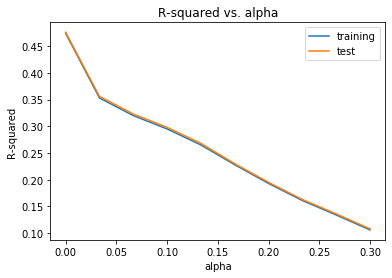

In [14]:
# load basic packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.3f}'.format
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv

# load visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
colors = sns.color_palette()

# load sklearn packages
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder


# Import the cleaned dataset - data.csv.
df = pd.read_csv('/Users/frankstaszak/Desktop/207_team_project/data/data.csv')

# Descriptions of all variables other than the renamed ones

codebook = pd.read_csv("https://www.dropbox.com/s/yygyqp5yhqvmdiy/Description_Variables_simple.csv?dl=1")
summary = pd.DataFrame(df.describe().T, columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']).reset_index()
summary.rename(columns={"index": "variable_code"}, inplace=True)
codebook = codebook.merge(summary, how='inner')
pd.set_option('display.max_colwidth', None)
print('-'*100)
print('Descriptions of all variable labels other than the renamed ones')
print('-'*100)
codebook[['variable_code', 'variable_question']].style.set_properties(**{'text-align': 'left'})

# *** Define data, train, and evaluate model. ********************************************

# Define train/test data.
le = LabelEncoder()
df['language'] = le.fit_transform(df['language'].astype(str))
X = df.drop(columns=['Religion_over_science'])
# Define target (using dependent var - Religion_over_science)
y = df['Religion_over_science']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

scores_train = []
scores_test = []
scores_time = []
alpha = np.linspace(0.0001, 0.3, 10)

for i in alpha:
    start_time = time.time()
    model = make_pipeline(preprocessor, Lasso(alpha=i))
    X_train, X_test, y_train, y_test = train_test_split(df[cols_X], df['Religion_over_science'], random_state=123, test_size=0.2)
    _ = model.fit(X_train, y_train)
    scores_train.append(model.score(X_train, y_train).round(3)) # in-the-sample score
    scores_test.append(model.score(X_test, y_test).round(3)) # out-of-the-sample score
    scores_time.append(time.time() - start_time) # time elapse for this model

report = pd.DataFrame({
    'alpha': alpha,
    'R2 (train)': scores_train,
    'R2 (test)': scores_test,
    'Time (sec)': scores_time
})

display(report)

plt.plot(alpha, scores_train, label='training')
plt.plot(alpha, scores_test, label='test')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('R-squared')
plt.title('R-squared vs. alpha')
plt.show()
plt.close()


#### Evaluation: 
We observe that as the alpha weight increases, the R-squared score decreases. The coefficients in the regression model display a value closer to zero as the alpha weight increases. This relationship indicates that the observed outcomes of the model decline based on the degree to which the alpha weighting increased.

Furthermore, the regression modeled nearly forty eight percent of the outcomes at its peak.



<font size="2">Sources:</font><font size="1"> 
*  sklearn.linear_model.Lasso. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
*  sklearn.model_selection.RepeatedKFold. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html
*  Lasso and Elastic Net for Sparse Signals. https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_and_elasticnet.html#sphx-glr-auto-examples-linear-model-plot-lasso-and-elasticnet-py
*  sklearn.metrics.r2_score. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
*  What is the Difference Between Test and Validation Datasets? Brownlee, Jason. 2017  https://machinelearningmastery.com/difference-test-validation-datasets/
*  Repeated k-Fold Cross-Validation for Model Evaluation in Python. Brownlee, Jason. 2020 https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/</font>

In [15]:
# Helper function for finding the top five features.

def top5features(train, index=cols_X):
    print('-'*100)
    print('Feature importance based on feature permutation')
    print('-'*100)

    result = permutation_importance(
        train, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )

    forest_importances = pd.Series(result.importances_mean, index=index)

    forest_importances.sort_values(ascending=False).plot(kind='bar', figsize=(20,5), color=colors)
    plt.title("Feature importances using permutation on full model")
    plt.ylabel("Mean accuracy decrease")
    plt.show()
    plt.close()

    print("-" * 100)
    print("Top 5 most important features")
    print("-" * 100)
    top5 = forest_importances.sort_values(ascending=False).head(5)
    print(top5)
    print("""
    Note: descriptions for feature labels below""")
    display(codebook[codebook['variable_code'].isin(top5.index)][['variable_code', 'variable_question']].style.hide_index())

/Users/frankstaszak/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/Users/frankstaszak/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/frankstaszak/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10837.775871056858, tolerance: 4.130062566898311
  positive)


----------------------------------------------------------------------------------------------------
Feature importance based on feature permutation
----------------------------------------------------------------------------------------------------


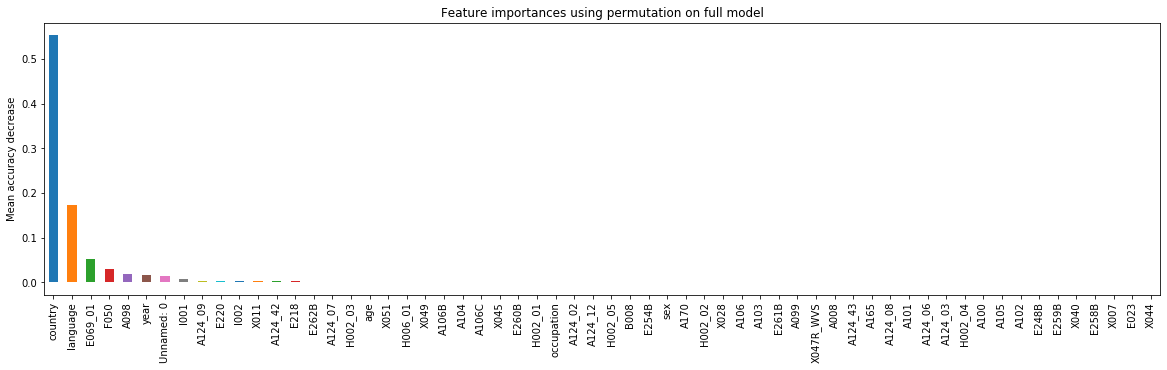

----------------------------------------------------------------------------------------------------
Top 5 most important features
----------------------------------------------------------------------------------------------------
country    0.553
language   0.172
E069_01    0.053
F050       0.029
A098       0.020
dtype: float64

    Note: descriptions for feature labels below


variable_code,variable_question
A098,"Now I am going to read out a list of voluntary organizations; for each one, could you tell me whether you are a member, an active member, an inactive member or not a member of that type of organization? Church or religious organization"
E069_01,"I am going to name a number of organizations. For each one, could you tell me how much confidence you have in them: is it a great deal of confidence, quite a lot of confidence, not very much confidence or none at all? The Churches (mosque, temple etc.)"
F050,"In which of the following things do you believe, if you believe in any? God"


In [18]:
import time
from sklearn.inspection import permutation_importance

alpha_best = int(report.loc[report['R2 (test)'] == float(report['R2 (test)'].max()), 'alpha'])
model = make_pipeline(preprocessor, Lasso(alpha=alpha_best))
X_train, X_test, y_train, y_test = train_test_split(df[cols_X], df['Religion_over_science'], random_state=123, test_size=0.2)
train = model.fit(X_train, y_train)

top5features(train)